# Analizando los datos para obtener información

Este notebook es una adaptación del [original de *Aurélien Gerón*](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb), de su libro: [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition. Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)

## Pasos previos

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

housing = pd.read_csv("./data/housing.csv") # Cargamos el dataset

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5]) # Añadimos categorías de renta para estratificar

train_set, test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42) # generamos los conjuntos de entrenamiento y de prueba

for set_ in (train_set, test_set):
    set_.drop("income_cat", axis=1, inplace=True) # Eliminamos la columna de estratificación de los conjuntos

In [2]:
housing = train_set.copy() # Copiamos el conjunto de entrenamiento para poder manipularlo sin afectar al original

## Visualización de datos geográficos

Vamos a crear un gráfico de dispersión de todos los distritos para visualizar los datos geográficos.

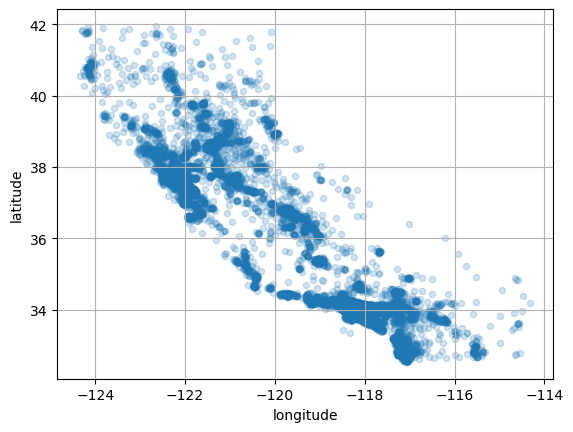

In [3]:
import matplotlib.pyplot as plt

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

Visualización de cada registro sobre su posición geográfica (latitud y longitud), con una escala de colores representar el precio medio de la vivienda y el tamaño de los círculos representando el número de habitantes.

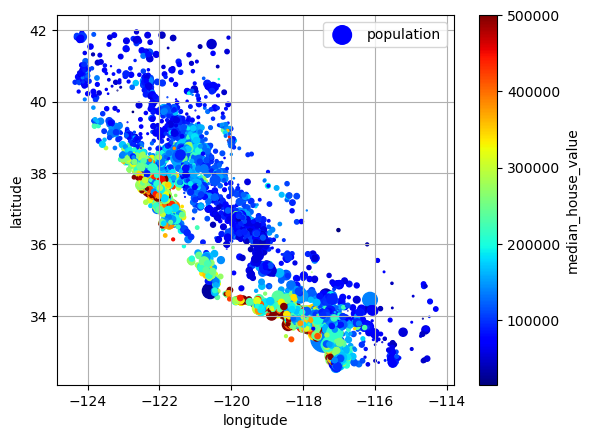

In [4]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, # el radio de cada círculo representa la población del distrito
             label="population", # etiqueta para la leyenda
             c="median_house_value", # el color de los puntos representa el valor medio de las casas
             cmap="jet", # utilizamos la paleta de colores "jet"
             colorbar=True,
             legend=True)
plt.show()

Posicionando lo mismo sobre un mapa.

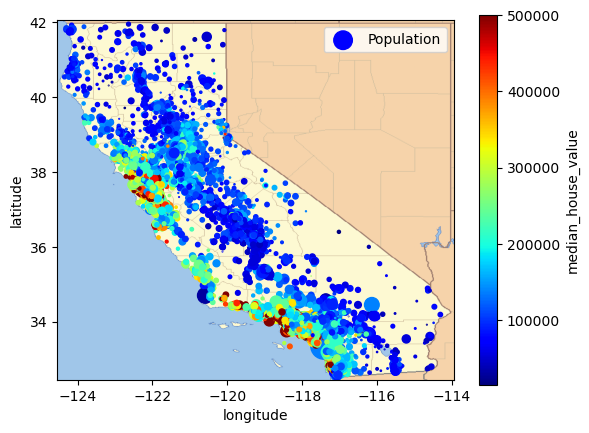

In [5]:
housing.plot(kind="scatter", x="longitude", y="latitude",
             s=housing["population"] / 100, # tamaño de los círculos proporcional a la población
             label="Population", 
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True)

california_img = plt.imread("./data/california.png")
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

plt.show()

Visualizando los valores de 'ocean_proximity' con colores geográficamente (será útil para cuando preprocesemos ésta variable categórica).

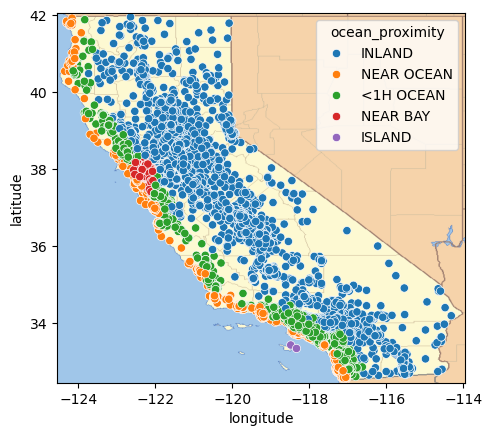

In [6]:
import seaborn as sns
import PIL
import matplotlib.pyplot as plt

sns.scatterplot(x="longitude", y="latitude", hue="ocean_proximity", data=housing)
axis = -124.55, -113.95, 32.45, 42.05 # límites de longitud y latitud de la imagen
plt.imshow(PIL.Image.open("./data/california.png", mode='r'), extent=axis)
plt.show()

## Buscando correlaciones

El método `corr()` de Pandas calcula el **coeficiente de correlación de Pearson** (PCC) entre cada par de atributos. Este coeficiente varía de -1 a 1 indicando el grado de correlación lineal entre dos variables. Cuando está cerca de 1, significa que hay una fuerte correlación positiva (las variables tienden a aumentar juntas). Cuando el coeficiente está cerca de -1, significa que hay una fuerte correlación negativa  (una variable disminuye cuando la otra aumenta). Finalmente, los coeficientes cercanos a 0 significan que no hay correlación lineal.
Usamos el argumento `numeric_only=True` para calcular la correlación solo entre las variables numéricas, ignorando la variable categórica 'ocean_proximity'.

In [7]:
corr_matrix = housing.corr(numeric_only=True) 

Teniendo esta matriz de correlación, vamos a ver de forma ordenada cuáles son las variables que más correlacionan con la **variable objetivo**, 'median_house_value'. El método `sort_values()` de Pandas nos permite ordenar los valores de una serie; además, podemos usar el parámetro `key` para pasar una una función que se aplicará a cada valor antes de ordenar. En este caso, queremos ordenar por el valor absoluto, ya que una correlación negativa fuerte es igual de interesante que una positiva.

In [8]:
corr_matrix["median_house_value"].sort_values(ascending=False, key=np.abs) # ordenamos los valores de la correlación con respecto al valor absoluto

median_house_value    1.000000
median_income         0.687151
latitude             -0.142673
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
longitude            -0.047466
population           -0.026882
Name: median_house_value, dtype: float64

Observamos que la variable que más correlaciona con 'median_house_value' es 'median_income', con un coeficiente de 0.69. Es por tanto, la ***feature*** que más determina el precio de la vivienda.

También podemos ver las correlaciones con un gráfico de dispersión de las variables más correlacionadas con 'median_house_value', usando la función `scatter_matrix` de Pandas. En la diagonal vemos que coloca, por defecto, sus histogramas (como los vistos al principio) ya que comparar una variable consigo misma solo nos daría una línea recta sin información útil.

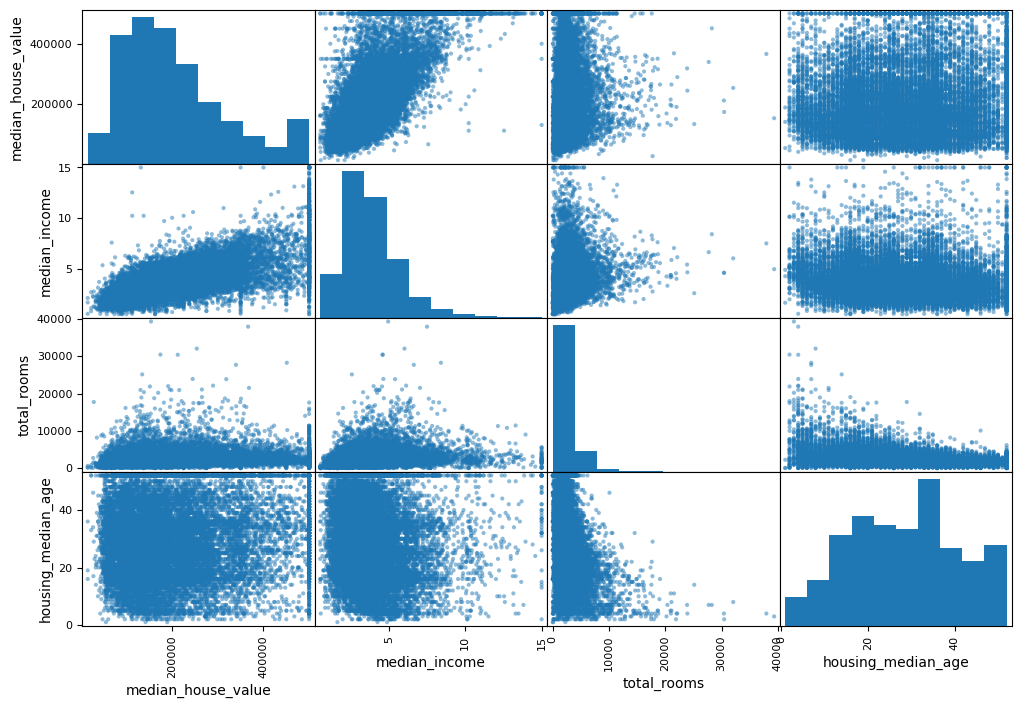

In [9]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

De nuevo vemos como la correlación más clara está con 'median_income', cuanto más se incrementa ésta, más se incrmente el precio medio de la vivienda. También podemos ver que el límite de 500,000 USD que hemos comentado antes se ve claramente en el gráfico, como una línea horizontal en la parte superior del eje y.

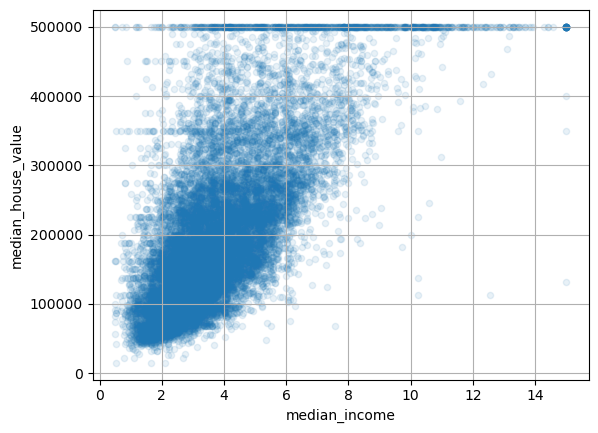

In [10]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
plt.show()

## Combinando atributos

A menudo tendrá sentido intentar combinar ciertas variables para obtener nuevas variables más útiles. Por ejemplo, el número total de habitaciones no es muy útil si no sabemos cuántas viviendas hay. Lo que realmente queremos es el número de habitaciones por vivienda. Del mismo modo, el número total de dormitorios por sí solo no es muy útil: probablemente queremos compararlo con el número de habitaciones. Y la población por vivienda también parece una combinación interesante de atributos para mirar. Vamos a crear estas nuevas variables.

Añadimos por lo tanto columnas con estas nuevas variables al dataframe y vemos sus correlaciones con 'median_house_value'.

In [11]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"] # número de habitaciones por casa
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"] # proporción de dormitorios con respecto al total de habitaciones
housing["people_per_house"] = housing["population"] / housing["households"] # número de personas por casa

In [12]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False, key=np.abs)

median_house_value    1.000000
median_income         0.687151
bedrooms_ratio       -0.259952
rooms_per_house       0.146255
latitude             -0.142673
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
longitude            -0.047466
population           -0.026882
people_per_house     -0.021991
Name: median_house_value, dtype: float64

Hemos conseguido un nuevo atributo "bedrooms_ratio" que tiene una correlación mucho mayor con "median_house_value" que el número total de habitaciones o dormitorios. Aparentemente, las casas con una menor relación dormitorios/habitaciones tienden a ser más caras. Además, el número de habitaciones por vivienda también tiene una correlación mayor que el número total de habitaciones o dormitorios.